# Capstone Project: Traffic Volume Analysis
---
Project notebook organisation:<br>
**1 - EDA and preprocessing** (current notebook)<br>
[2 - Modelling and insights](./2_modelling_and_insights.ipynb)<br>
[3 - Appendix](./appendix.ipynb)<br>
<br>
<br>

In [28]:
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

from PIL import Image
import cv2 as cv
from skimage import io
from skimage.exposure import histogram
from skimage.util import img_as_ubyte
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy import ndimage as ndi

sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction & problem statement
   ---

Estimation of traffic conditions is important in allowing commuters to decide on the best time and route of travel. This is an especially pertinent problem at the two causeways (Woodlands and Tuas) that bridge the strait between Singapore and Malaysia. On an average day, [350,000 travellers cross the Woodlands causeway alone](https://www.straitstimes.com/singapore/a-look-at-woodlands-checkpoint-singapores-first-and-last-line-of-defence), making it [one of the busiest overland border crossings in the region](https://infographics.channelnewsasia.com/interactive/causewayjam/index.html). For Singaporeans, crossing into Malaysia can take anywhere from 30 minutes at optimal conditions and several hours during popular crossing times such as Saturday mornings. Having an understanding of existing traffic conditions at the checkpoints would allow Singaporean commuters to make better decisions about whether or not to make the journey across at a given time. 

Currently, commuters rely on a list of websites that display static images from the [same traffic cameras API](https://data.gov.sg/dataset/traffic-images) offered by LTA (e.g. [[1]](https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/kje.html#trafficCameras), [[2]](http://www.jalanow.com/johor-singapore-live-traffic-cam.htm), [[3]](https://www.sgmytaxi.com/traffic-camera/), [[4]](http://www.checkpoint.sg/)), thus requiring them to guess how many cars were present before they visited the page and how long the current condition is expected to last. The smart phone app "Beat the Jam" went one step further and provides historic and predicted data on the time required to cross. However, as [they obtain this information from Google Maps](https://causewayjam.wordpress.com/2016/03/02/beat-the-jam-version-2-0-is-live/), it depends on crowd-sourced data and won't be as accurate as car counts obtained from real-time images.

The goal of this project is to use deep learning and image processing techniques to extract real-time traffic volume from traffic camera images. This has the potential to complement existing solutions on the market to allow better representations of traffic situations. Due to time limitations, the scope of this project is currently limited to daytime traffic at the Tuas Checkpoint. 

### Contents

1. [Data acquisition](#Data-acquisition)
2. [Preprocessing](#Preprocessing)
3. [EDA](#EDA)

## Executive summary
---

This project used traffic camera images obtained from the the [traffic cameras API](https://data.gov.sg/dataset/traffic-images) on Data.gov.sg. The low resolution of the images hindered the training of an object detection model. As such, in this project I used a background subtraction algorithm followed by several machine learning and deep learning approaches to predict the number of cars in each image.

The production (XGBoost) model extracts the number of cars from traffic images with relatively high accuracy (MAE = 6.59), thus providing a direct estimation of road congestion in contrast to the proxy-based model used by Google Maps, which bases their traffic information on a combination of real-time data sent by smartphones and historic travel times. However, what this model lacks is the ability to estimate travel times. The two approaches should therefore be considered complementary, and could be combined for a more well-rounded application that provides better recommendations to commuters.

The biggest limitation with the current approach to modelling traffic is that it produces a model that cannot be generalised to images from other cameras. Due to the low image qualities that hinders the training of an object detection model, the current model relies on a somewhat primitive approach of manual car labelling. As each traffic camera is angled differently with regards to the cars on the road, they each produce images with different patterns of occlusion. Therefore, a model trained on labelled images from one camera would not be able to accurately predict the number of cars in images from a camera at a different angle or location.

## Data acquisition
---

Traffic camera images were obtained using the publicly available [traffic images API](https://data.gov.sg/dataset/traffic-images) from Data.gov.sg. This API is maintained by the Land Transport Authority (LTA) of Singapore. Images are updated once every minute or so. 
<img src="../graphics/traffic_cameras_map.png" width=500px align=center>

The data used for this project consists of images from the camera ID 4713 as shown in the map above, from about 8 am to 6 pm on days where the weather is clear. Details of the datasets are as follows:

|data|date|time|number of images|
|--|--|--|--|
|training| 2019 Nov 15| 0901 - 1643 hrs|349 
|validation| 2019 Nov 14| 0815 - 1621 hrs|389
|test| 2019 Nov 17| 0846 - 1800 hrs|457

The script for scraping from this API as well as instructions for how to use it can be found in the `image_scraper` folder under the main project directory.

All three datasets were hand-labelled with the number of cars using the [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html) by the Visual Geometry Group. While it would have been ideal to have one person label all images to ensure consistency, due to time constraints and the large number of cars in the images this was not possible. Instead, the training and validation sets were labelled by one person, and the test set by another. An example of a labelled image is shown below:
<img src="../graphics/labeller_example.png" width=500px align=center>

## Preprocessing
---

As can be seen below, the raw images have several limitations. Firstly, their resolutions are very low (480 px by 640 px). Secondly, the camera is angled such that cars further from the camera are occluded by cars closer to the camera.

This implicated the modelling approach, as it meant that counting cars by object detection was not possible. To train the model to predict the number of cars in each frame, I instead used a background subtraction algorithm (as explained below), together with manually labelled images.

original image dimensions:  (480, 640, 3)


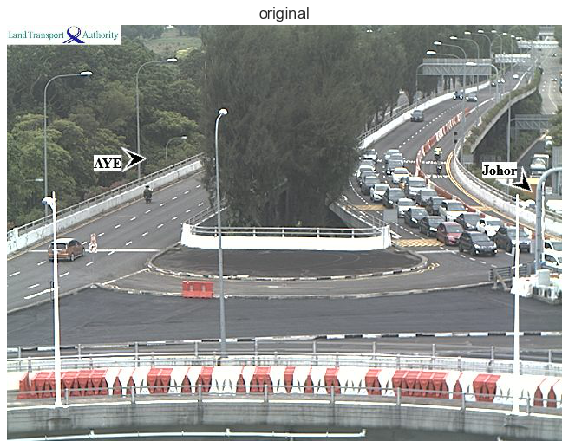

In [29]:
path_in = '../sample_images/'
img_files = [f for f in os.listdir(path_in) if f != '.DS_Store']
image_orig = io.imread(path_in + img_files[6])
print("original image dimensions: ", image_orig.shape)

plt.subplots(figsize=(8, 7))
plt.imshow(image_orig)
plt.title('original', fontsize=16)
plt.axis('off')
plt.tight_layout()

### Image processing

#### Crop images

The images are first cropped to the road of interest, as a first step to reduce noise in the final preprocessed image. The motorbike lane is also cropped out. Cars far away from the camera are cropped as individual cars become more indiscernable the further they are from the camera. Parts of image on the bottom right are cropped as well to remove structures (i.e. poles) that block the view of the cars. 

In [30]:
cropped_images = []

for image in img_files:
    file = io.imread(path_in + image)

    # crop image
    file = file[60:320, 380:]
    # black out unnecessary parts in cropped image
    # right polygon
    file[:185, 240:] = 0
    file[:, 205:] = 0
    file[:170, 200:] = 0
    file[:165, 180:] = 0
    file[:158, 160:] = 0
    file[:153, 150:] = 0
    file[:143, 144:] = 0
    file[50:135, 130:] = 0
    file[60:130, 120:] = 0
    file[70:125, 110:] = 0
    file[80:115, 100:] = 0
    file[90:110, 95:] = 0
    # top left polygon
    for length, width in zip(np.arange(5,96,5), np.arange(150,0,-10)):
        file[:length,:width]=0
    # bottom left polygon
    for length, width in zip(np.arange(150,245, 5), np.arange(0,190,10)):
        file[length:,:width]=0

    # save frame
    cropped_images.append(file)

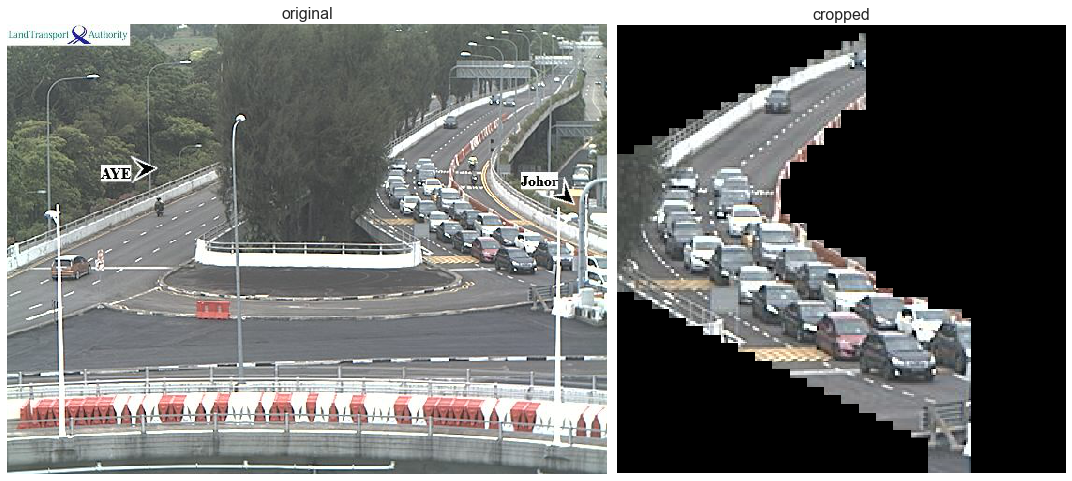

In [31]:
# plot original and cropped images for comparison
fig, ax = plt.subplots(ncols = 2, figsize=(15, 7), gridspec_kw={'width_ratios': [5.35, 4]})
ax[0].imshow(image_orig)
ax[0].set_title('original', fontsize=16)
ax[1].imshow(cropped_images[6])
ax[1].set_title('cropped', fontsize=16)
for ax in ax:
    ax.axis('off')
plt.tight_layout()

#### Background subtraction

Background subtraction is possible as the images are from a static camera. Most fundamentally, background subtraction is the process of taking the difference in pixel values between a target image and a reference image. The pixels (e.g. those of the road surface) that did not change would return a value of 0 and are deemed the background.

The background subtractor class in the `OpenCV` library applies a `history` and a `learningRate` parameter to this fundamental concept, which controls for changes in certain background conditions (such as light) that can occur over time. As shown below, after applying the background subtractor the cropped traffic images, cars are extracted as the foreground (in non-black pixels), whereas the road is blacked out as the background.

Even with the `history` and the `learningRate` parameters, however, the background subtractor performs poorly when there are sudden changes in light regime between consecutive frames, such as the sun emerging from behind clouds. Due to the rather large amount of time the images are spaced apart (1 minute), this wasn't a rare occurrence. 

In [16]:
# define background subtractor
bg_sub = cv.createBackgroundSubtractorMOG2(history = 5, varThreshold=100, detectShadows=False)

image_foreground = []

for frame in cropped_images:
    # apply background subtractor to frames
    foreground = bg_sub.apply(frame,learningRate=0.7)
    
    image_foreground.append(foreground)

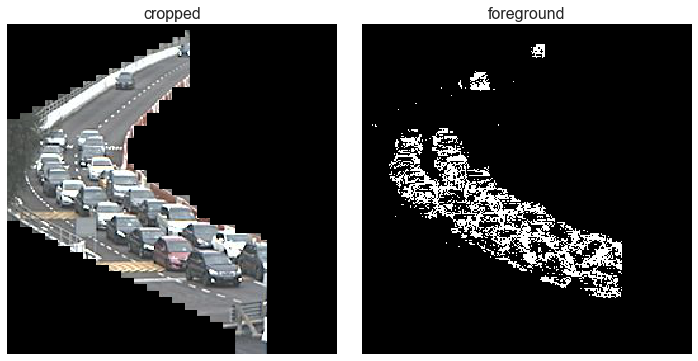

In [17]:
# plot cropped images and foreground for comparison
fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
ax[0].imshow(cropped_images[6])
ax[0].set_title('cropped', fontsize=16)
ax[1].imshow(image_foreground[6], cmap=plt.cm.gray)
ax[1].set_title('foreground', fontsize=16)
for ax in ax:
    ax.axis('off')
plt.tight_layout()

#### Remove noise

As shown in the image above, the foreground extracted by the background subtractor has a small amount of noise - where pixels are pale but are not cars. Different denoise methods (offered by the `scikit-images` library) are compared below. The total variation method performed best in this case, removing slightly more noise than the bilateral method while preserving most of the shapes of the cars.

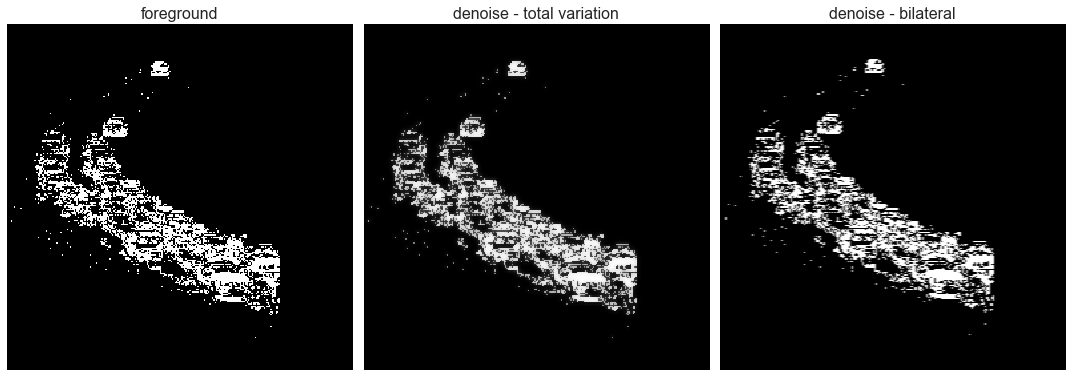

In [18]:
# try different denoise methods
denoise_tv = denoise_tv_chambolle(image_foreground[8], weight=0.15, multichannel=False)
denoise_bilat = denoise_bilateral(image_foreground[8], sigma_spatial=0.7,multichannel=False)

# compare different denoise methods
fig, ax = plt.subplots(ncols = 3, figsize=(15, 6))
ax[0].imshow(image_foreground[8], cmap=plt.cm.gray)
ax[0].set_title('foreground', fontsize=16)
ax[1].imshow(denoise_tv, cmap=plt.cm.gray)
ax[1].set_title('denoise - total variation', fontsize=16)
ax[2].imshow(denoise_bilat, cmap=plt.cm.gray)
ax[2].set_title('denoise - bilateral', fontsize=16)
for ax in ax:
    ax.axis('off')
plt.tight_layout()

#### Thresholding

Thresholding works by converting all pixels below a specified threshold to 0 (black) and those above to 1 (white), and is applied next to further enhance the foreground. According to the image histogram below, most of the image (as expected) is black. To avoid losing too much of the foreground, a conservative threshold value of 0.15 is used.

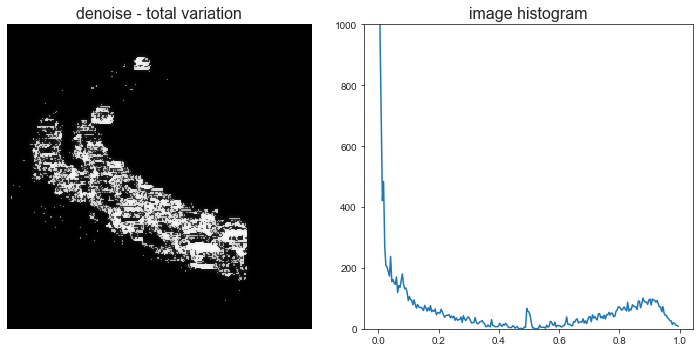

In [19]:
hist, hist_centers = histogram(denoise_tv)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(denoise_tv, cmap=plt.cm.gray)
ax[0].set_title('denoise - total variation', fontsize=16)
ax[0].axis('off')

ax[1].plot(hist_centers, hist)
ax[1].set_ylim(0,1000)
ax[1].set_title('image histogram', fontsize=16)
plt.tight_layout()

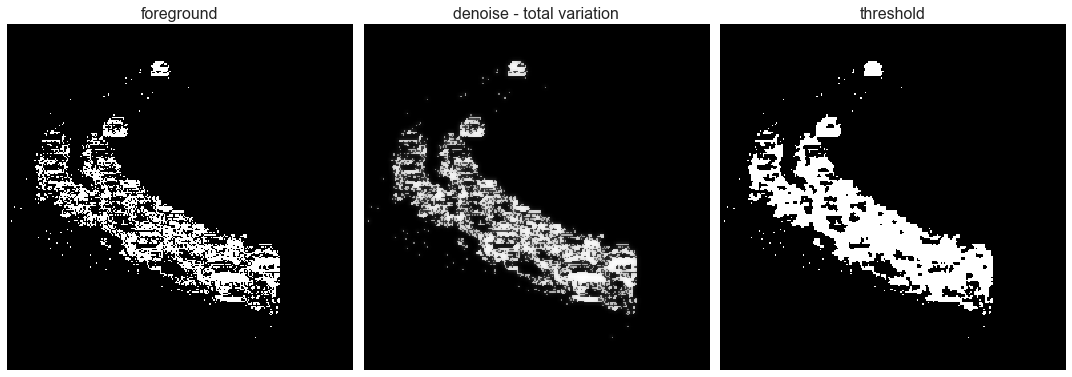

In [20]:
# threshold
ret,thresh = cv.threshold(denoise_tv,0.15,255,cv.THRESH_BINARY)

# plot threshold results
fig, ax = plt.subplots(ncols = 3, figsize=(15, 6))
ax[0].imshow(image_foreground[8], cmap=plt.cm.gray)
ax[0].set_title('foreground', fontsize=16)
ax[1].imshow(denoise_tv, cmap=plt.cm.gray)
ax[1].set_title('denoise - total variation', fontsize=16)
ax[2].imshow(thresh, cmap=plt.cm.gray)
ax[2].set_title('threshold', fontsize=16)
for ax in ax:
    ax.axis('off')
plt.tight_layout()

#### Infilling

The final step of image processing was infilling. The `scipy` function `binary_fill_holes` is used to fill up areas of black pixels that are enclosed by white pixels (i.e. fill up the holes). The result is a more consistent area of white pixels that correspond better to the spaces taken up by cars in the original image. A summary of results following each image processing step is shown below.

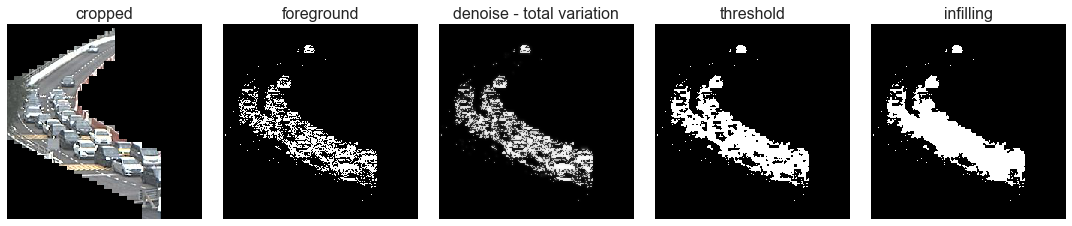

In [21]:
# infilling
fill = ndi.binary_fill_holes(thresh)

# plot image processing results
fig, ax = plt.subplots(ncols = 5, figsize=(15, 6))
ax[0].imshow(cropped_images[8])
ax[0].set_title('cropped', fontsize=16)
ax[1].imshow(image_foreground[8], cmap=plt.cm.gray)
ax[1].set_title('foreground', fontsize=16)
ax[2].imshow(denoise_tv, cmap=plt.cm.gray)
ax[2].set_title('denoise - total variation', fontsize=16)
ax[3].imshow(thresh, cmap=plt.cm.gray)
ax[3].set_title('threshold', fontsize=16)
ax[4].imshow(fill, cmap=plt.cm.gray)
ax[4].set_title('infilling', fontsize=16)
for ax in ax:
    ax.axis('off')
plt.tight_layout()

### Split images

Each image is further split into 16 segments, which will serve as additional features for modelling.

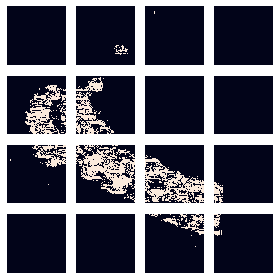

In [22]:
def split_image(input_img):
    width = int(input_img.shape[0]/4)
    split = []
    for h in [1,2,3,4]:
        for w in [1,2,3,4]:
            img = input_img[(h - 1)*width : width*h,
                            (w - 1)*width : width*w]
            split.append(img)
    return split

testsplit = split_image(image_foreground[5])

# sanity check
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize=(4,4))
ax = ax.ravel()
for key, img in enumerate(testsplit):
    ax[key].imshow(img)
for ax in ax:
    ax.axis('off')
plt.tight_layout()

### Final preprocessing function

Note that due to size limitations, the original images listed in the directories below are not included in the this repository.

#### Preprocess x (images)

In [23]:
def preprocess_foreground(image_folder):
    # input path for image folder and output path
    img_files = [f for f in os.listdir(image_folder) if f != '.DS_Store']

    # extract date and time
    date = [x[5:15] for x in img_files]
    time = [x[-12:-4] for x in img_files]

    hist = 5
    bg_sub = cv.createBackgroundSubtractorMOG2(history = hist, detectShadows=False)
    
    white_px = []
    img = []
    split_img = pd.DataFrame(columns=np.arange(1,17))
    
    for file in range(len(img_files)):
        filename = image_folder + img_files[file]
        image = io.imread(filename)

        # crop image
        image = image[60:320, 380:]
        image[:185, 240:] = 0
        image[:, 205:] = 0
        image[:170, 200:] = 0
        image[:165, 180:] = 0
        image[:158, 160:] = 0
        image[:153, 150:] = 0
        image[:143, 144:] = 0
        image[50:135, 130:] = 0
        image[60:130, 120:] = 0
        image[70:125, 110:] = 0
        image[80:115, 100:] = 0
        image[90:110, 95:] = 0
        for length, width in zip(np.arange(5,96,5), np.arange(150,0,-10)):
            image[:length,:width]=0
        for length, width in zip(np.arange(150,245, 5), np.arange(0,190,10)):
            image[length:,:width]=0

        # subtract background
        fg = bg_sub.apply(image, learningRate=0.7)
        denoise_tv = denoise_tv_chambolle(fg, weight=0.15, multichannel=False)
        ret,thresh = cv.threshold(denoise_tv, 0.15, 255, cv.THRESH_BINARY)
        fill = ndi.binary_fill_holes(thresh)
        fill = img_as_ubyte(fill)
        
        foreground = fill.ravel()
        white_px.append(len(foreground[foreground == 255]))
        img.append(fill)
       
        # split images
        split = split_image(fill)
        split_df = pd.DataFrame([split], columns=np.arange(1,17))
        split_img = split_img.append(split_df)
          
    
    foreground = pd.DataFrame({'date':date,
                               'time':time,
                               'whites':white_px,
                               'image':img})
    foreground.date = pd.to_datetime(foreground.date)
    foreground.time = pd.to_datetime(foreground.time)#.dt.time
    # join with split-up images
    split_img.reset_index(inplace=True)
    foreground = foreground.join(split_img)
    foreground.drop('index',axis=1,inplace=True)
    # slicing out frames used to process bg
    foreground = foreground[hist:].reset_index(drop=True)

    return foreground 

In [24]:
path_in = ['../../../../../Desktop/images4model/model_reg2/train/',
           '../../../../../Desktop/images4model/model_reg2/val/',
           '../../../../../Desktop/images4model/model_reg2/test/']
labels = ['train',
          'val',
          'test']

list_of_dfs = {}
for path_in, label in zip(path_in, labels):
    list_of_dfs[label] =  preprocess_foreground(path_in)

xtrain, xval, xtest = list_of_dfs['train'], list_of_dfs['val'], list_of_dfs['test']

In [50]:
# export files
xtrain.to_pickle('../data/xtrain.zip')
xval.to_pickle('../data/xval.zip')
xtest.to_pickle('../data/xtest.zip')

In [28]:
print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(349, 20)
(389, 20)
(457, 20)


#### Preprocess y (labels/number of cars)

In [3]:
train_labels = pd.read_csv('../../../../../Desktop/images4model/model_reg2/train_labels.csv')
val_labels = pd.read_csv('../../../../../Desktop/images4model/model_reg2/val_labels.csv')
test_labels = pd.read_csv('../../../../../Desktop/images4model/model_reg2/test_labels.csv')

In [23]:
def make_y (df):
    # drop extra columns
    df2 = df.drop(['file_size','file_attributes','region_attributes'], axis=1)
    
    # extract number of cars
    df2 = df2.groupby('#filename').count()[['region_count']]
    
    # clean-up
    df2.reset_index(inplace=True)
    df2.rename(columns={'#filename':'filename','region_count':'num_cars'}, inplace=True)
    
    # slicing out frames used to process bg
    df2 = df2[5:].reset_index(drop=True)
    return df2

ytrain = make_y(train_labels)
yval = make_y(val_labels)
ytest = make_y(test_labels)

# crop out unlabelled images (389 onwards)
yval = yval.loc[:388,:]

print(ytrain.shape)
print(yval.shape)
print(ytest.shape)

(349, 2)
(389, 2)
(457, 2)


In [24]:
# export files
ytrain.to_pickle('../data/ytrain.zip')
yval.to_pickle('../data/yval.zip')
ytest.to_pickle('../data/ytest.zip')

## EDA
---

Looking at the graphs below, there appear to be a roughly linear relationship between the number of white pixels and the number of cars. However, there appears to be a point (between 40 - 60 cars) where the amount of white pixels stopped increasing with increasing number of cars.

In [42]:
# get mean pixel value
xtrain_eda = xtrain[['image',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]].applymap(lambda x:x.mean())

xtrain_eda = xtrain_eda.join(xtrain.whites)
train_eda = xtrain_eda.join(ytrain.num_cars)
train_eda.head()

,image,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,whites,num_cars
0,57.016642,8.691124,121.072189,26.133728,0.0,161.389349,126.986982,0.0,0.0,56.009467,191.325444,155.353846,15.692308,0.0,1.689941,41.705325,6.216568,15115,49
1,60.509689,9.717160,122.279290,24.866272,0.0,172.675740,123.486391,0.0,0.0,57.337278,205.750296,159.095858,14.304142,0.0,4.345562,59.147929,15.149112,16041,45
2,58.959320,9.656805,121.736095,24.564497,0.0,169.899408,124.814201,0.0,0.0,59.570414,193.739645,155.897041,14.364497,0.0,1.991716,54.138462,12.976331,15630,39
3,53.448151,8.630769,122.882840,26.314793,0.0,159.156213,126.021302,0.0,0.0,51.060355,148.533728,150.102959,14.726627,0.0,2.715976,36.816568,8.208284,14169,45
4,58.887648,8.630769,121.856805,27.220118,0.0,159.639053,122.701775,0.0,0.0,47.559763,199.473373,160.846154,14.424852,0.0,1.810651,64.338462,13.700592,15611,47


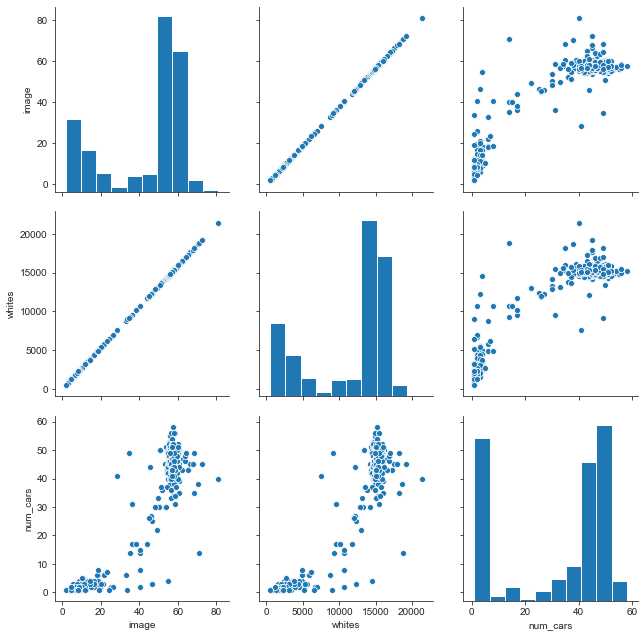

In [48]:
sns.pairplot(train_eda[['image','whites','num_cars']], size=3)

Model training is carried out in the next notebook ([modelling and insights](./2_modelling_and_insights)).